# stroke-alert

**Predictable variable: stroke**  
We are aiming to early predict and alert the stroke risk based on individual's demographical and health data.

##### Libraries : 

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from scipy.stats import pointbiserialr, chi2_contingency
import numpy as np

##### Original data:

Making a copy of original dataframe - "df_original"

In [90]:
df = pd.read_csv("AVC.csv")
df_original = df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# New try

## Data comprehension

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Data has:  
1 independent variable **stroke**,  
10 dependent variables (id is not dependent variable):  
- 3 continuous variables - **age**, **avg_glucose_level**, **bmi**  
- 7 categorical variables:  
  - 2 binary variables - **hypertension**, **heart_disease**
  - 5 nominal variables - **gender**, **ever_married**, **work_type**, **Residence_type**, **smoking_status**  
  
**Data has missing bmi values.**  

### Stroke (imbalanced)

Data distribution:

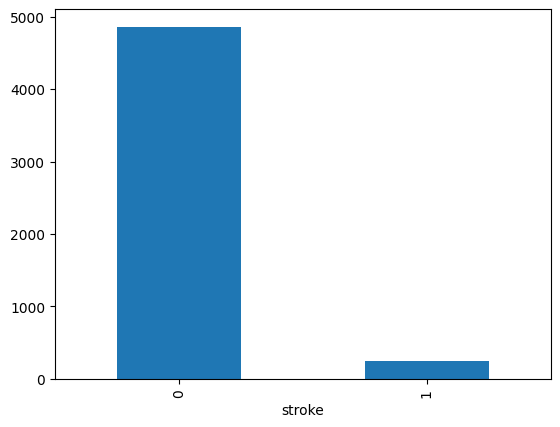

In [92]:
df.stroke.value_counts().plot(kind='bar')
plt.show()

There is a high imbalance in the data between the positive and negative stroke classes.

In [93]:
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [94]:
stroke_percentage = 249*100/(249+4861)
round(stroke_percentage, 2)

4.87

Almost **95%** of data records are in stroke class 0.

Since there are null bmi values, dealing with these missing values is an essential step to address before proceeding further to balancing classes.

### Age

Data distribution:

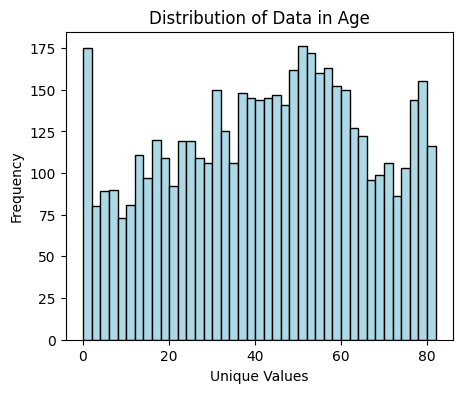

In [95]:
plt.figure(figsize=(5, 4))
plt.hist(df['age'], bins=41, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Age')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Stroke frequency based on the age distribution in the data:

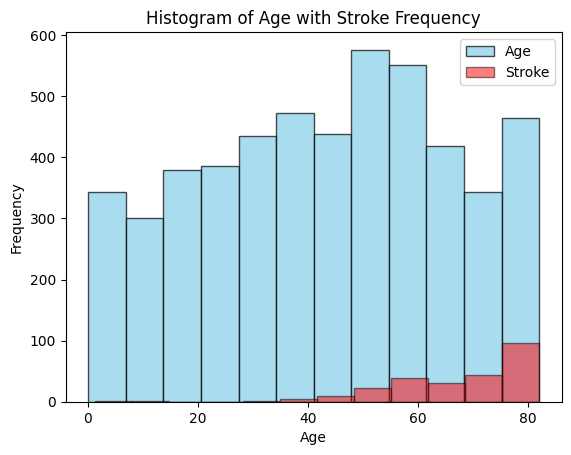

In [120]:
number_of_bins = 12
plt.hist(df['age'], bins=number_of_bins, color='skyblue', alpha=0.7, edgecolor='black', label='Age')
plt.hist(df[df['stroke'] == 1]['age'], bins=number_of_bins, color='red', alpha=0.5, edgecolor='black', label='Stroke')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()
plt.show()

In [103]:
age_min = df['age'].min()
age_max = df['age'].max()
bins = number_of_bins
bin_size = (age_max - age_min) / bins
bin_end = age_min
for bin_no in range(bins):
    if bin_no == 3:
        break
    bin_start = bin_end
    bin_end = bin_start + bin_size
    print('bin ', bin_no+1, ': ', round(bin_start, 2), ' - ', round(bin_end, 2))

bin  1 :  0.08  -  6.91
bin  2 :  6.91  -  13.73
bin  3 :  13.73  -  20.56


Searching for outliers of age based on stroke with a box plot:

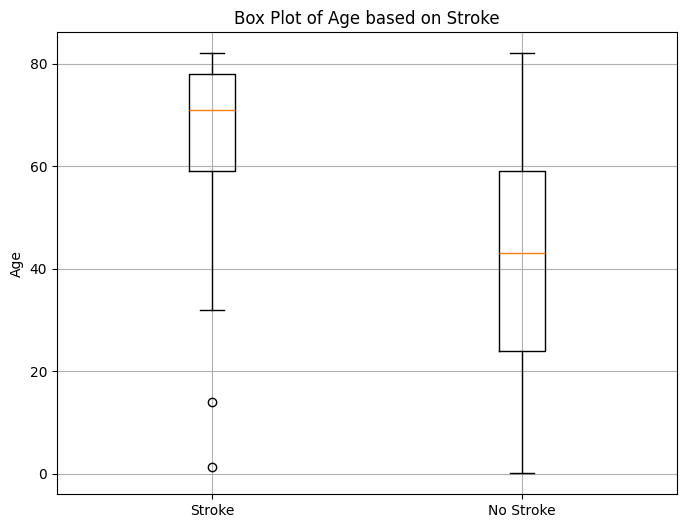

In [97]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['stroke'] == 1]['age'], df[df['stroke'] == 0]['age']], labels=['Stroke', 'No Stroke'])
plt.ylabel('Age')
plt.title('Box Plot of Age based on Stroke')
plt.grid(True)
plt.show()

In [99]:
df_age_outliers = df[(df['stroke'] == 1) & (df['age'] < 20)]
df_age_outliers

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


### Average Glucose Level

Data distribution:

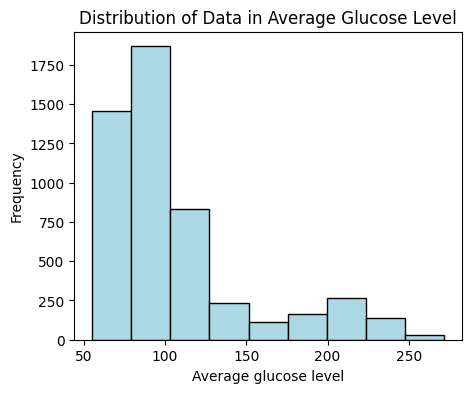

In [125]:
plt.figure(figsize=(5, 4))
plt.hist(df['avg_glucose_level'], bins=9, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Average Glucose Level')
plt.xlabel('Average glucose level')
plt.ylabel('Frequency')
plt.show()

Average glucose level distribution in both stroke classes:

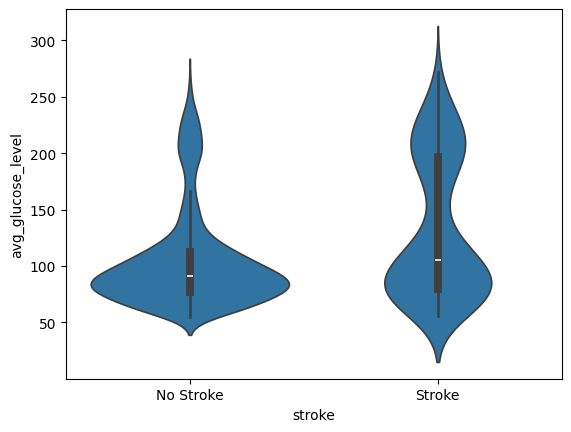

In [122]:
sns.violinplot(x='stroke', y='avg_glucose_level', data=df)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

Data of Age versus average glucose level in both stroke classes:

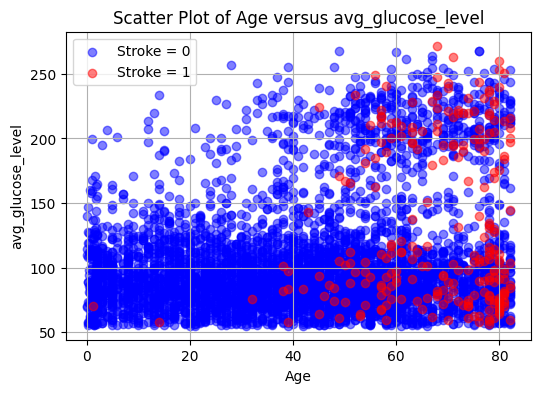

In [119]:
plt.figure(figsize=(6, 4))
plt.scatter(df[df['stroke'] == 0]['age'], df[df['stroke'] == 0]['avg_glucose_level'], color='blue', alpha=0.5, label='Stroke = 0')
plt.scatter(df[df['stroke'] == 1]['age'], df[df['stroke'] == 1]['avg_glucose_level'], color='red', alpha=0.5, label='Stroke = 1')
plt.title('Scatter Plot of Age versus avg_glucose_level')
plt.xlabel('Age')
plt.ylabel('avg_glucose_level')
plt.grid(True)
plt.legend()
plt.show()

### BMI

Data distribution:

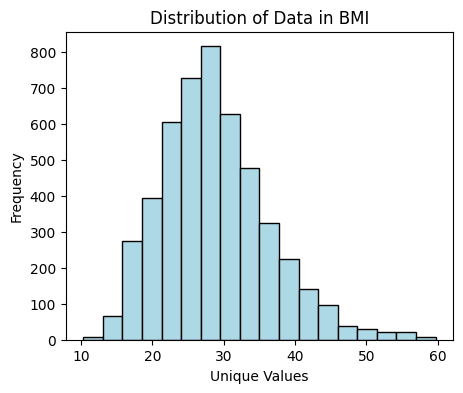

In [137]:
df_original_bmi_cleaned = df.drop(df[(df['bmi'] > 60)].index)
plt.figure(figsize=(5, 4))
plt.hist(df_original_bmi_cleaned['bmi'], bins=18, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in BMI')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Data distribution and outliers:

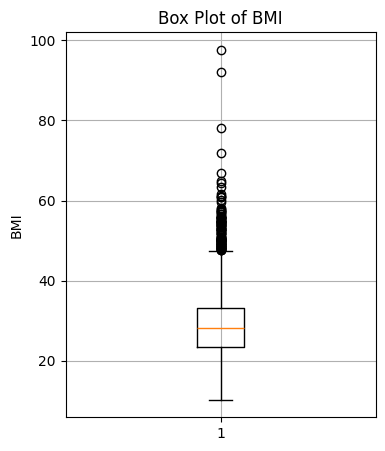

In [140]:
df_bmi = df[df['bmi'].notnull()]
plt.figure(figsize=(4, 5))
plt.boxplot(df_bmi['bmi'])
plt.ylabel('BMI')
plt.title('Box Plot of BMI')
plt.grid(True)
plt.show()

Data distribution and outliers in both stroke classes:

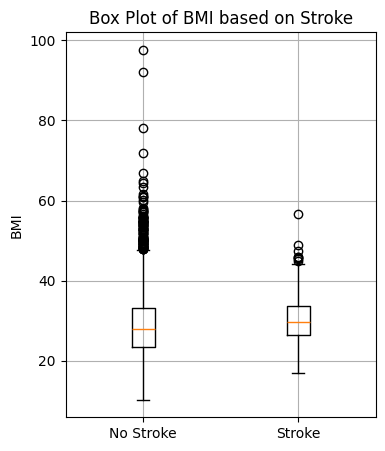

In [141]:
plt.figure(figsize=(4, 5))
plt.boxplot([df_bmi[df_bmi['stroke'] == 0]['bmi'], df_bmi[df_bmi['stroke'] == 1]['bmi']], labels=['No Stroke', 'Stroke'])
plt.ylabel('BMI')
plt.title('Box Plot of BMI based on Stroke')
plt.grid(True)
plt.show()

Age versus BMI in both stroke classes:

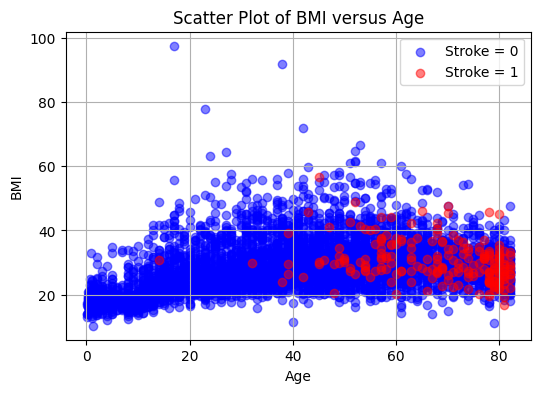

In [142]:
plt.figure(figsize=(6, 4))
plt.scatter(df[df['stroke'] == 0]['age'], df[df['stroke'] == 0]['bmi'], color='blue', alpha=0.5, label='Stroke = 0')
plt.scatter(df[df['stroke'] == 1]['age'], df[df['stroke'] == 1]['bmi'], color='red', alpha=0.5, label='Stroke = 1')
plt.title('Scatter Plot of BMI versus Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

It seems like there may be a few anomalies in the data where age > 30 and very low BMI < 15. These anomalies might not represent the real world data.

### Hypertension (imbalanced)

Data distribution:

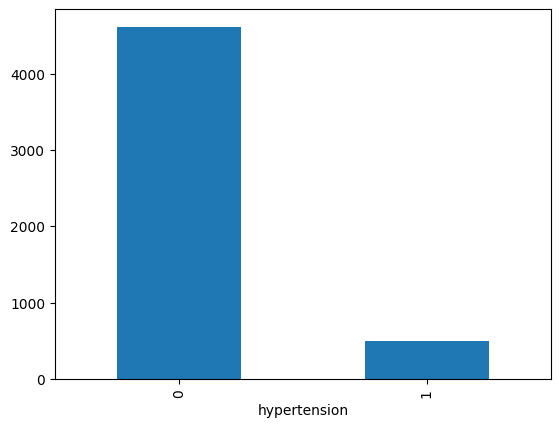

In [145]:
df.hypertension.value_counts().plot(kind='bar')
plt.show()

Data distribution in Positive stroke class:

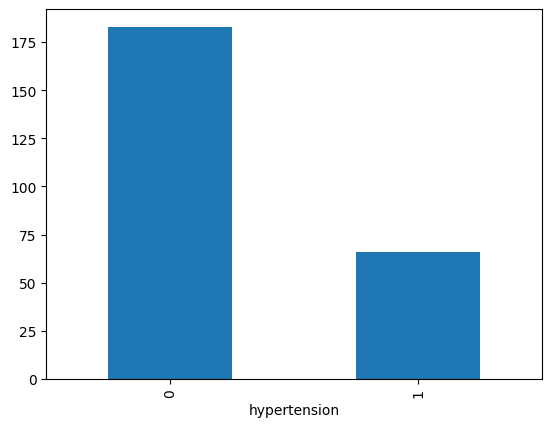

In [146]:
df_stroke = df[df['stroke'] == 1]
df_stroke.hypertension.value_counts().plot(kind='bar')
plt.show()

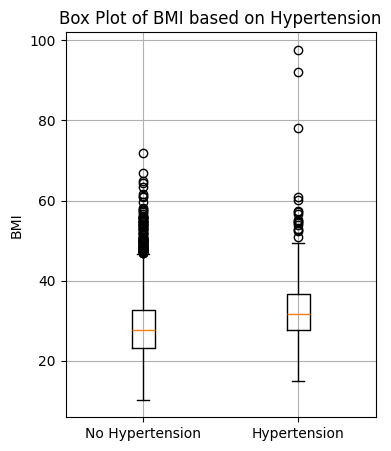

In [149]:
plt.figure(figsize=(4, 5))
plt.boxplot([df_bmi[df_bmi['hypertension'] == 0]['bmi'], df_bmi[df_bmi['hypertension'] == 1]['bmi']], labels=['No Hypertension', 'Hypertension'])
plt.ylabel('BMI')
plt.title('Box Plot of BMI based on Hypertension')
plt.grid(True)
plt.show()

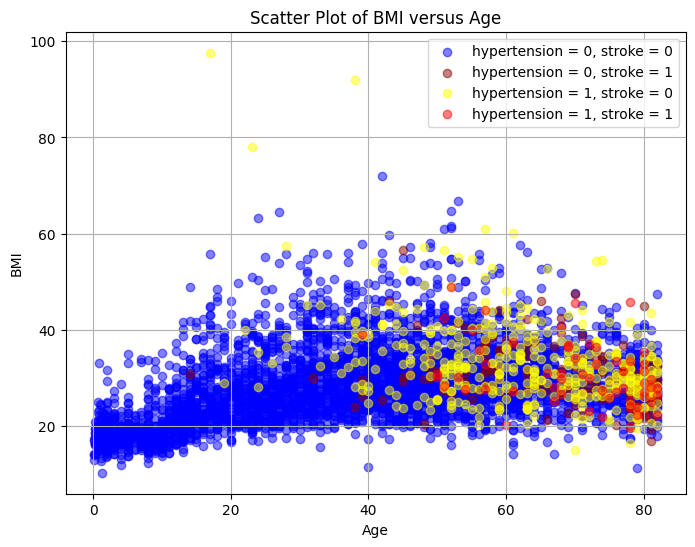

In [162]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['hypertension'] == 0) & (df['stroke'] == 0)]['age'], df[(df['hypertension'] == 0) & (df['stroke'] == 0)]['bmi'], color='blue', alpha=0.5, label='hypertension = 0, stroke = 0')
plt.scatter(df[(df['hypertension'] == 0) & (df['stroke'] == 1)]['age'], df[(df['hypertension'] == 0) & (df['stroke'] == 1)]['bmi'], color='darkred', alpha=0.5, label='hypertension = 0, stroke = 1')
plt.scatter(df[(df['hypertension'] == 1) & (df['stroke'] == 0)]['age'], df[(df['hypertension'] == 1) & (df['stroke'] == 0)]['bmi'], color='yellow', alpha=0.5, label='hypertension = 1, stroke = 0')
plt.scatter(df[(df['hypertension'] == 1) & (df['stroke'] == 1)]['age'], df[(df['hypertension'] == 1) & (df['stroke'] == 1)]['bmi'], color='red', alpha=0.5, label='hypertension = 1, stroke = 1')
plt.title('Scatter Plot of BMI versus Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

### Heart Disease (imbalanced)

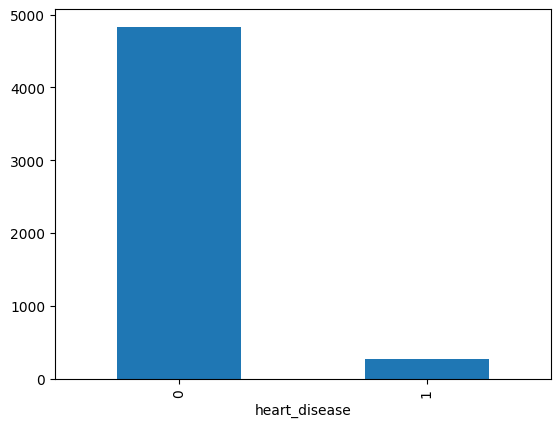

In [163]:
df.heart_disease.value_counts().plot(kind='bar')
plt.show()

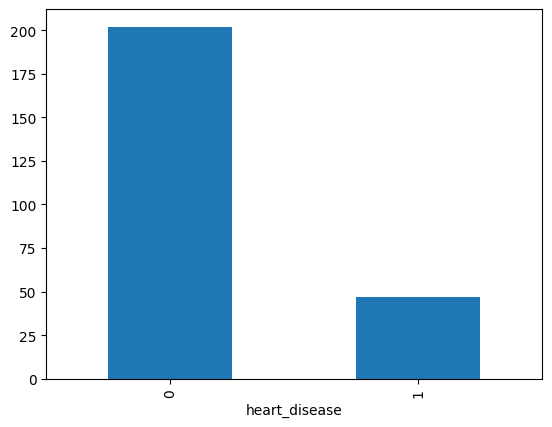

In [164]:
df_stroke = df[df['stroke'] == 1]
df_stroke.heart_disease.value_counts().plot(kind='bar')
plt.show()

### Gender

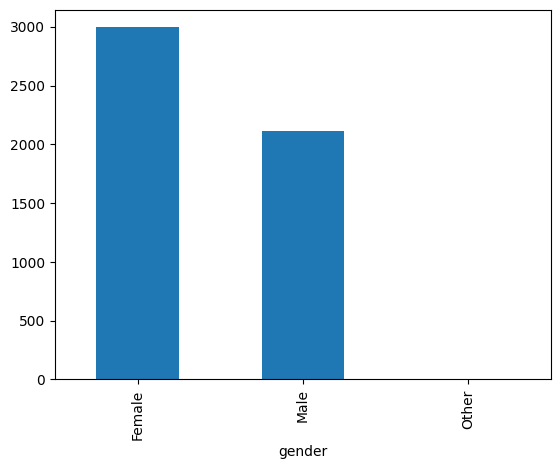

In [165]:
df.gender.value_counts().plot(kind='bar')
plt.show()

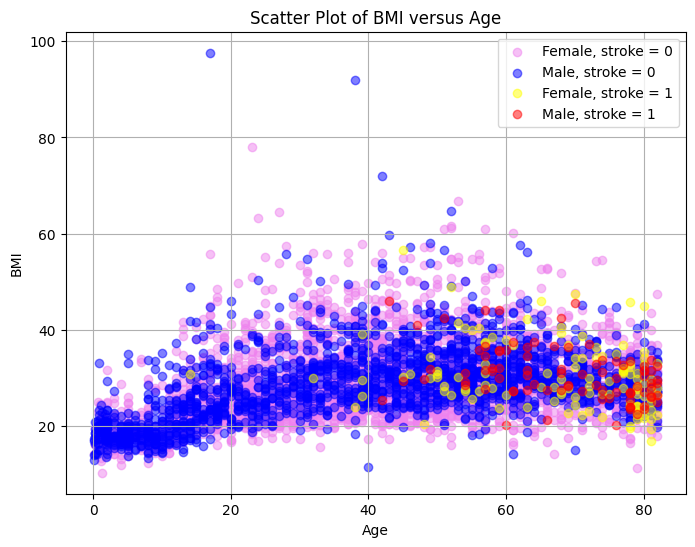

In [169]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['gender'] == 'Female') & (df['stroke'] == 0)]['age'], df[(df['gender'] == 'Female') & (df['stroke'] == 0)]['bmi'], color='violet', alpha=0.5, label='Female, stroke = 0')
plt.scatter(df[(df['gender'] == 'Male') & (df['stroke'] == 0)]['age'], df[(df['gender'] == 'Male') & (df['stroke'] == 0)]['bmi'], color='blue', alpha=0.5, label='Male, stroke = 0')
plt.scatter(df[(df['gender'] == 'Female') & (df['stroke'] == 1)]['age'], df[(df['gender'] == 'Female') & (df['stroke'] == 1)]['bmi'], color='yellow', alpha=0.5, label='Female, stroke = 1')
plt.scatter(df[(df['gender'] == 'Male') & (df['stroke'] == 1)]['age'], df[(df['gender'] == 'Male') & (df['stroke'] == 1)]['bmi'], color='red', alpha=0.5, label='Male, stroke = 1')
plt.title('Scatter Plot of BMI versus Age')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

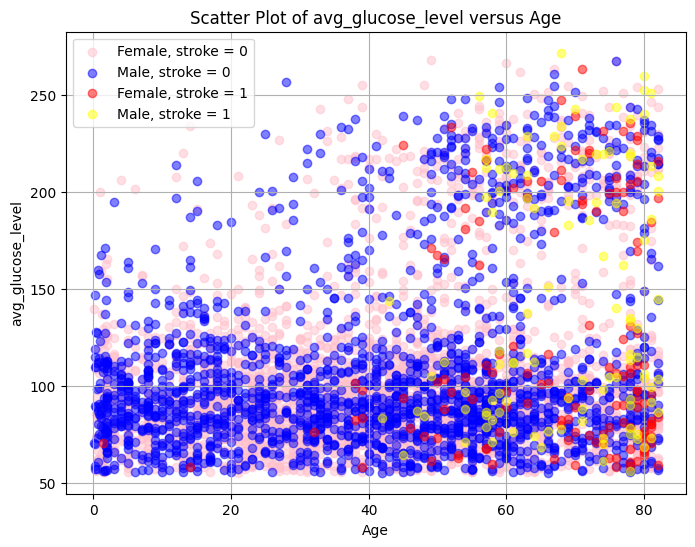

In [182]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['gender'] == 'Female') & (df['stroke'] == 0)]['age'], df[(df['gender'] == 'Female') & (df['stroke'] == 0)]['avg_glucose_level'], color='pink', alpha=0.5, label='Female, stroke = 0')
plt.scatter(df[(df['gender'] == 'Male') & (df['stroke'] == 0)]['age'], df[(df['gender'] == 'Male') & (df['stroke'] == 0)]['avg_glucose_level'], color='blue', alpha=0.5, label='Male, stroke = 0')
plt.scatter(df[(df['gender'] == 'Female') & (df['stroke'] == 1)]['age'], df[(df['gender'] == 'Female') & (df['stroke'] == 1)]['avg_glucose_level'], color='red', alpha=0.5, label='Female, stroke = 1')
plt.scatter(df[(df['gender'] == 'Male') & (df['stroke'] == 1)]['age'], df[(df['gender'] == 'Male') & (df['stroke'] == 1)]['avg_glucose_level'], color='yellow', alpha=0.5, label='Male, stroke = 1')
plt.title('Scatter Plot of avg_glucose_level versus Age')
plt.xlabel('Age')
plt.ylabel('avg_glucose_level')
plt.grid(True)
plt.legend()
plt.show()

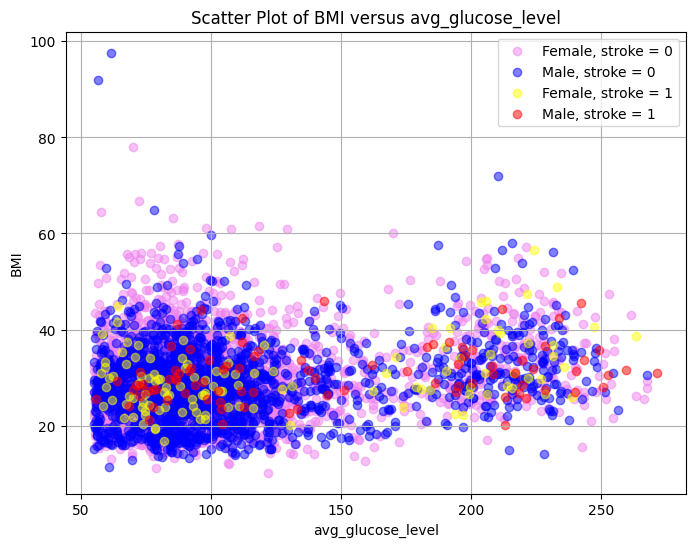

In [170]:
plt.figure(figsize=(8, 6))
plt.scatter(df[(df['gender'] == 'Female') & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['gender'] == 'Female') & (df['stroke'] == 0)]['bmi'], color='violet', alpha=0.5, label='Female, stroke = 0')
plt.scatter(df[(df['gender'] == 'Male') & (df['stroke'] == 0)]['avg_glucose_level'], df[(df['gender'] == 'Male') & (df['stroke'] == 0)]['bmi'], color='blue', alpha=0.5, label='Male, stroke = 0')
plt.scatter(df[(df['gender'] == 'Female') & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['gender'] == 'Female') & (df['stroke'] == 1)]['bmi'], color='yellow', alpha=0.5, label='Female, stroke = 1')
plt.scatter(df[(df['gender'] == 'Male') & (df['stroke'] == 1)]['avg_glucose_level'], df[(df['gender'] == 'Male') & (df['stroke'] == 1)]['bmi'], color='red', alpha=0.5, label='Male, stroke = 1')
plt.title('Scatter Plot of BMI versus avg_glucose_level')
plt.xlabel('avg_glucose_level')
plt.ylabel('BMI')
plt.grid(True)
plt.legend()
plt.show()

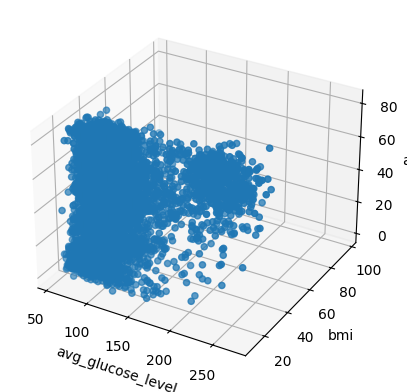

In [187]:
x = df['avg_glucose_level']
y = df['bmi']
z = df['age']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('avg_glucose_level')
ax.set_ylabel('bmi')
ax.set_zlabel('age')
plt.show()

In [ ]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Apply label encoding to the categorical variables
encoder = LabelEncoder()
df[categorical_vars] = df[categorical_vars].apply(encoder.fit_transform)

### Ever Married

### Work Type 

### Residence Type

### Smoking Status

## Data cleaning

In [69]:
df[['age','avg_glucose_level','bmi']].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


In [74]:
columns_to_exclude = ['stroke', 'id', 'age', 'avg_glucose_level', 'bmi']
df_categorical_data = df.drop(columns=columns_to_exclude)
df_categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          5110 non-null   object
 1   hypertension    5110 non-null   int64 
 2   heart_disease   5110 non-null   int64 
 3   ever_married    5110 non-null   object
 4   work_type       5110 non-null   object
 5   Residence_type  5110 non-null   object
 6   smoking_status  5110 non-null   object
dtypes: int64(2), object(5)
memory usage: 279.6+ KB


# / New try

## Data Cleaning

In [ ]:
df.info()

BMI has 201 empty values

### Initial data cleaning  
**Deleting 4 records stroke=0**

Converting categorical variables to numerical representations

In [ ]:
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Apply label encoding to the categorical variables
encoder = LabelEncoder()
df[categorical_vars] = df[categorical_vars].apply(encoder.fit_transform)

Deleting columns:  
- ID,  
- ever_married

Records:  
- where BMI values are superior to 69

There is significant correlation between ever_married and age: **68%**

In [ ]:
continuous_var = 'age'

binary_var = 'ever_married'

print(f'Point-biserial correlation coefficients for {continuous_var}:')
correlation_coefficient, p_value = pointbiserialr(df[continuous_var], df[binary_var])
print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')


Deleting columns ID, ever_married, records where BMI values are superior to 69:

In [ ]:
#df = df.drop('id', axis=1)
df = df.drop('ever_married', axis=1)
df = df.drop(df[df['bmi'] >= 69].index) #IMC de 59 correspond à 170cm 200 Kg, les valeurs max sont à 97,6 (abérant)

Data records where BMI >= 69 (from original dataframe):

In [ ]:
high_bmi_df = df_original[(df_original['bmi'] >= 69)]
high_bmi_df.sort_values(by='bmi', ascending=False)

In [ ]:
plt.figure(figsize=(4, 5))
df_original.boxplot(column='bmi')
plt.title('Box Plot of BMI')
plt.ylabel('BMI')
plt.show()

Changing 'smoking_status' 0 ('Unknown') values to null:

In [ ]:
# df['smoking_status'] = df['smoking_status'].replace(0, None)

### Gender (more women than men)  
**Deleting 1 record stroke=0**

In [ ]:
df_original.gender.value_counts().plot(kind='bar')
plt.show()

In [ ]:
df.gender.value_counts().plot(kind='bar')
plt.show()

Removing 1 data sample with gender 'Other' (2)

In [ ]:
df_gender_other = df_original[df_original['gender'] == 'Other']
df_gender_other

In [ ]:
df = df.drop(df[df['gender'] == 2].index)

In [ ]:
df_stroke = df[df['stroke'] == 1]
df_stroke.gender.value_counts().plot(kind='bar')
plt.show()

### Residence type

In [ ]:
df.Residence_type.value_counts().plot(kind='bar')
plt.show()

### Work type (imbalanced)

In [ ]:
df_original.work_type.value_counts().plot(kind='bar')
plt.show()

In [ ]:
df.work_type.value_counts().plot(kind='bar')
plt.show()

In [ ]:
df_stroke = df[df['stroke'] == 1]
df_stroke.work_type.value_counts().plot(kind='bar')
plt.show()

### Smoking status  
**There are 1368 records where smoking_status is Unknown**

Original data:

In [ ]:
df_original.smoking_status.value_counts().plot(kind='bar')
plt.show()

Initially cleaned dataframe data where nominal textual variables are converted to numerical:

In [ ]:
df.smoking_status.value_counts().plot(kind='bar')
plt.show()

Calculating Null smoking_status values:

In [ ]:
df_smoking_unknown = df[df['smoking_status']==0]
print(len(df_smoking_unknown))

**There are 1368 records where smoking_status is Unknown**

### Age  
**Deleting 1 record where age<=2.08, stroke=1,  
Deleting 174 records age<=2.08 and stroke=0**

Calculating the histogram bin edges

In [ ]:
# Calculate histogram values and bin edges
hist_values, bin_edges = np.histogram(df['age'], bins=41, range=(df['age'].min(), df['age'].max()))

# Print start and end points of each bin
for i, (start, end) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    if i == 3: break
    print(f'Bin {i + 1}: Start: {start}, End: {end}')

Age < 2.08 (first histogram bin) - values where stroke = 1: 

In [ ]:
test_df = df[(df['age'] <= 2.08) & (df['stroke'] == 1)]
test_df.sort_values(by='age', ascending=False)

**One record with Positive stroke class will be removed**

Age < 2.08 (first histogram bin) - all values: 

In [ ]:
test_df = df[(df['age'] <= 2.08)]
print('In total Records to be deleted when age <= 2.08:', len(test_df))

**Deleting the records where age < 2.08 (175 records)**

In [ ]:
df = df.drop(df[df['age'] <= 30].index)

C:\Users\rutta\AppData\Local\Temp\ipykernel_3680\1829559703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(random_indices, inplace=True)


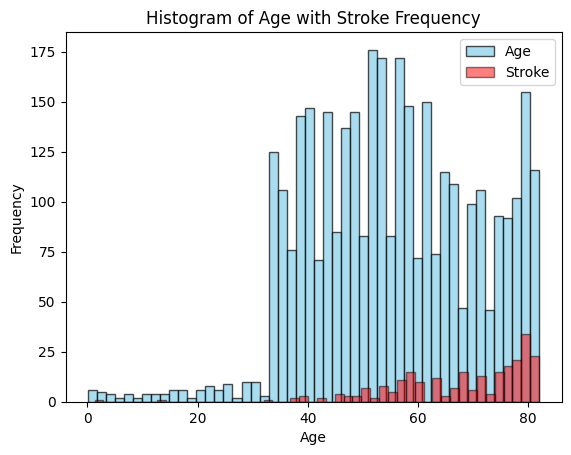

In [87]:
filtered_df = df[(df['age'] <= 32.02) & (df['stroke'] == 0)]
random_indices = np.random.choice(filtered_df.index, size=100, replace=False)
filtered_df.drop(random_indices, inplace=True)
df = df.drop(filtered_df.index)

plt.hist(df['age'], bins=50, color='skyblue', alpha=0.7, edgecolor='black', label='Age')
plt.hist(df[df['stroke'] == 1]['age'], bins=50, color='red', alpha=0.5, edgecolor='black', label='Stroke')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()

plt.show()

In [ ]:
df_original_bmi_cleaned = df_original.drop(df_original[(df_original['bmi'] > 60)].index)

### Average glucose level

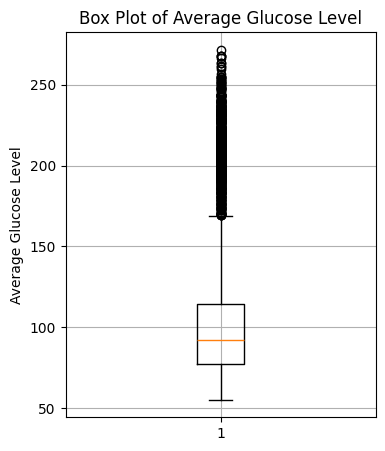

In [109]:
plt.figure(figsize=(4, 5))
plt.boxplot(df['avg_glucose_level'])
plt.ylabel('Average Glucose Level')
plt.title('Box Plot of Average Glucose Level')
plt.grid(True)
plt.show()

In [ ]:
df['avg_glucose_level'].describe()

In [110]:
df_avg_glucose_with_stroke = df[df['stroke'] == 1]
df_avg_glucose_with_stroke['avg_glucose_level'].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

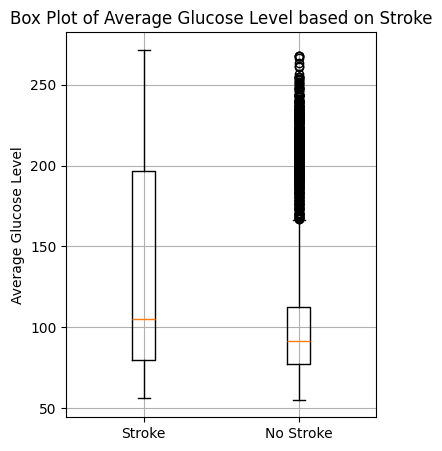

In [112]:
plt.figure(figsize=(4, 5))
plt.boxplot([df[df['stroke'] == 1]['avg_glucose_level'], df[df['stroke'] == 0]['avg_glucose_level']], labels=['Stroke', 'No Stroke'])
plt.ylabel('Average Glucose Level')
plt.title('Box Plot of Average Glucose Level based on Stroke')
plt.grid(True)
plt.show()

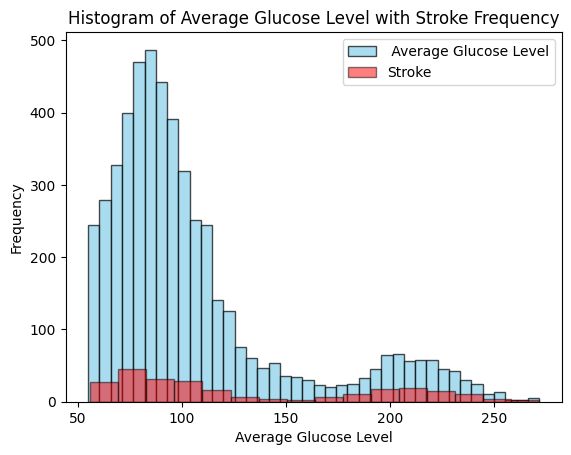

In [113]:
plt.hist(df['avg_glucose_level'], bins=40, color='skyblue', alpha=0.7, edgecolor='black', label=' Average Glucose Level')

# Overlay the frequency line of stroke
plt.hist(df[df['stroke'] == 1]['avg_glucose_level'], bins=16, color='red', alpha=0.5, edgecolor='black', label='Stroke')

# Add labels and title
plt.xlabel('Average Glucose Level')
plt.ylabel('Frequency')
plt.title('Histogram of Average Glucose Level with Stroke Frequency')
plt.legend()

# Show plot
plt.show()

Average Glucose Level might falsely predict the Stroke as it sees all Negative Stroke class as outliers.

### BMI  
**There are 195 records where bmi is Unknown**  
**Deleting 4 records stroke=0**

Calculating null bmi values:

In [126]:
df_bmi_unknown = df[df['bmi'].isnull()]
print(len(df_bmi_unknown))

201


**There are 195 empty BMI values**

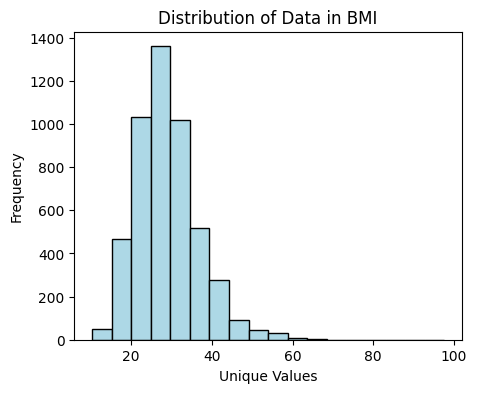

In [131]:
plt.figure(figsize=(5, 4))
plt.hist(df['bmi'], bins=18, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in BMI')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

BMI values are distrubuted correctly.

Data distribution on BMI with Stroke frequency:

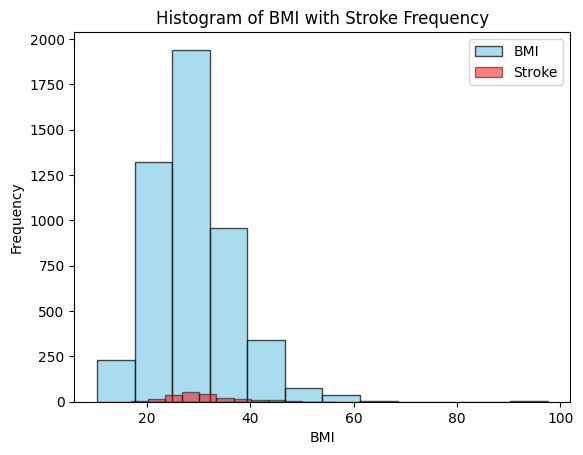

In [133]:
plt.hist(df['bmi'], bins=12, color='skyblue', alpha=0.7, edgecolor='black', label='BMI')

# Overlay the frequency line of stroke
plt.hist(df[df['stroke'] == 1]['bmi'], bins=12, color='red', alpha=0.5, edgecolor='black', label='Stroke')

# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.title('Histogram of BMI with Stroke Frequency')
plt.legend()

# Show plot
plt.show()

In [135]:
df_low_BMI = df[(df['bmi'] < 15) & (df['age'] > 30)]
df_low_BMI.sort_values(by='age')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2187,59993,Male,40.0,0,0,Yes,Private,Rural,60.96,11.5,never smoked,0
2661,59762,Male,61.0,0,0,Yes,Private,Urban,227.98,14.2,Unknown,0
1930,28309,Female,67.0,0,0,Yes,Private,Urban,82.09,14.1,never smoked,0
3307,3205,Female,79.0,0,0,Yes,Self-employed,Urban,79.03,11.3,Unknown,0


In [ ]:
df = df.drop(df[(df['bmi'] < 15) & (df['age'] > 30)].index)

### Dealing with missing values

Grouping the values of continuous variables (*age*, *average glucose level* and *bmi*) based on histogram with minimum logical number of bins for records grouping and finding missing BMI values.

Working with **df_grouped_cont_v** from here.

In [ ]:
df_grouped_cont_v = df.copy()

##### Age

In [ ]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['age'], bins=13, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Age')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
hist_values, _ = np.histogram(df_grouped_cont_v['age'], bins=13, range=(df_grouped_cont_v['age'].min(), df_grouped_cont_v['age'].max()))
df_grouped_cont_v['age_histogram'] = np.digitize(df_grouped_cont_v['age'], bins=np.arange(df_grouped_cont_v['age'].min(), df_grouped_cont_v['age'].max(), (df_grouped_cont_v['age'].max()-df_grouped_cont_v['age'].min())/13))
df_grouped_cont_v

##### Average glucose level

In [ ]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['avg_glucose_level'], bins=8, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in Average Glucose Level')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
hist_values, _ = np.histogram(df_grouped_cont_v['avg_glucose_level'], bins=8, range=(df_grouped_cont_v['avg_glucose_level'].min(), df_grouped_cont_v['avg_glucose_level'].max()))
df_grouped_cont_v['avg_glucose_level_histogram'] = np.digitize(df_grouped_cont_v['avg_glucose_level'], bins=np.arange(df_grouped_cont_v['avg_glucose_level'].min(), df_grouped_cont_v['avg_glucose_level'].max(), (df_grouped_cont_v['avg_glucose_level'].max()-df_grouped_cont_v['avg_glucose_level'].min())/8))
df_grouped_cont_v

##### BMI

In [ ]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['bmi'], bins=9, color='lightblue', edgecolor='black')
plt.title('Distribution of Data in BMI')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
hist_values, _ = np.histogram(df_grouped_cont_v['bmi'], bins=9, range=(df_grouped_cont_v['bmi'].min(), df_grouped_cont_v['bmi'].max()))
df_grouped_cont_v['bmi_histogram'] = np.digitize(df_grouped_cont_v['bmi'], bins=np.arange(df_grouped_cont_v['bmi'].min(), df_grouped_cont_v['bmi'].max(), (df_grouped_cont_v['bmi'].max()-df_grouped_cont_v['bmi'].min())/9))
df_grouped_cont_v

##### Imputing missing BMI values

df_grouped_cont_v with 195 empty BMI values:

In [ ]:
df_grouped_cont_v.info()

Grouping the df_grouped_cont_v data by all categorical parameters and continuous variables grouped to numerical histogram bin numbers:

In [ ]:
grouped_data = df_grouped_cont_v.groupby(['gender', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'smoking_status', 'stroke', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    if group_data['bmi'].isnull().any():
        print('New group: ', group_name)
        print(group_data)
        print()

In [ ]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()
print('unknown_bmi_ids: ', sorted(unknown_bmi_ids), '\n')
df_bmi_unknown.sort_values(by='age', ascending=False)

Calculating the average BMI value for each group and filling missing values in the group with the group average:

In [ ]:
for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi


In [ ]:
filtered_df = df_grouped_cont_v[df_grouped_cont_v['id'].isin(unknown_bmi_ids)]
filtered_df.sort_values(by='age', ascending=False)

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown before imputation:', len(df_bmi_unknown))

In [ ]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

##### **After imputation 124 BMI values remain empty** 

In [ ]:
continuous_vars = ['age', 'avg_glucose_level', 'bmi']
continuous_df = df[continuous_vars].copy()
continuous_df.corr(method='pearson')

correlation_matrix = continuous_df.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between continuous variables')
plt.show()

In [ ]:
df_without_null_bmi = df.dropna()
continuous_vars = ['bmi']

binary_vars = ['gender', 'hypertension', 'heart_disease', 'Residence_type', 'work_type', 'smoking_status']

for continuous_var in continuous_vars:
    print(f'Point-biserial correlation coefficients for {continuous_var}:')
    for binary_var in binary_vars:
        # Calculate the point-biserial correlation coefficient
        correlation_coefficient, p_value = pointbiserialr(df_without_null_bmi[continuous_var], df_without_null_bmi[binary_var])
        print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')
    print('\n')

Median: Use the median when the distribution of BMI values is skewed or when there are outliers present. The median is less sensitive to outliers compared to the mean and provides a robust measure of central tendency.

In [ ]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()
print('unknown_bmi_ids: ', sorted(unknown_bmi_ids), '\n')
df_bmi_unknown.sort_values(by='age', ascending=False)

In [ ]:
grouped_data = df_grouped_cont_v.groupby(['hypertension', 'heart_disease', 'work_type', 'smoking_status', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi
        print('New group: ', group_name)
        print(group_data)
        print()

In [ ]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

In [ ]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()
print('unknown_bmi_ids: ', sorted(unknown_bmi_ids), '\n')
df_bmi_unknown.sort_values(by='age', ascending=False).head()

In [ ]:
grouped_data = df_grouped_cont_v.groupby(['hypertension', 'work_type', 'smoking_status', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi
        print('New group: ', group_name)
        print(group_data)
        print()

In [ ]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

In [ ]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()
print('unknown_bmi_ids: ', sorted(unknown_bmi_ids), '\n')
df_bmi_unknown.sort_values(by='age', ascending=False).head()

In [ ]:
grouped_data = df_grouped_cont_v.groupby(['work_type', 'smoking_status', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi
        print('New group: ', group_name)
        print(group_data)
        print()

In [ ]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

In [ ]:
df_bmi_unknown = df_grouped_cont_v[df_grouped_cont_v['bmi'].isnull()]
# Extract id values of records with unknown BMI
unknown_bmi_ids = df_bmi_unknown['id'].tolist()
print('unknown_bmi_ids: ', sorted(unknown_bmi_ids), '\n')
df_bmi_unknown.sort_values(by='age', ascending=False).head()

In [ ]:
grouped_data = df_grouped_cont_v.groupby(['work_type', 'age_histogram', 'avg_glucose_level_histogram'])

for group_name, group_data in grouped_data:
    nan_bmi_indices = group_data[group_data['bmi'].isnull()].index
    if nan_bmi_indices.any():
        group_average_bmi = group_data['bmi'].mean()
        group_average_bmi = round(group_average_bmi, 2)
        df_grouped_cont_v.loc[nan_bmi_indices, 'bmi'] = group_average_bmi
        print('New group: ', group_name)
        print(group_data)
        print()

In [ ]:
# Iterate over the unknown BMI IDs and update corresponding records in df
for idx in unknown_bmi_ids:
    bmi_value = df_grouped_cont_v.loc[df_grouped_cont_v['id'] == idx, 'bmi'].iloc[0]
    df.loc[df['id'] == idx, 'bmi'] = bmi_value

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
print('Records in the df where bmi is unknown after imputation:', len(df_bmi_unknown))

In [ ]:
df_bmi_unknown = df[df['bmi'].isnull()]
df_bmi_unknown

In [ ]:
df = df.drop(df[(df['id'] == 51852)].index)

### BMI vs Age  
**Deleting 9 records stroke=0**


Analyzing BMI versus Age outliers:

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='age_histogram', y='bmi', data=df_grouped_cont_v)
plt.title('Box Plot of BMI versus Age (df_grouped_cont_v)')
plt.xlabel('Age histogram bins')
plt.ylabel('BMI')
plt.show()

Age histogram that represent age groups:

In [ ]:
plt.figure(figsize=(5, 4))
plt.hist(df_grouped_cont_v['age'], bins=13, edgecolor='black')
plt.title('Distribution of Data in Age')
plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.show()

Records that have BMI > 60:

In [ ]:
df_high_BMI = df[(df['bmi'] >= 60)]
print(len(df_high_BMI), ' records:')
df_high_BMI.sort_values(by='age', ascending=False)

All 9 records are have stroke Negative class. Deleting these outliers:

In [ ]:
df = df.drop(df[df['bmi'] >= 60].index) 

### Resampling

Imbalanced variables (except for stroke): gender (take men), work_type (exclude 4), hypertension (take 1), heart_disease (take 1)

In [ ]:
df_age_balance = df_original.drop(df_original[(df_original['age'] < 60)].index)

In [ ]:
plt.hist(df['age'], bins=16, color='skyblue', alpha=0.7, edgecolor='black', label='Age')

# Overlay the frequency line of stroke
plt.hist(df[df['stroke'] == 1]['age'], bins=16, color='red', alpha=0.5, edgecolor='black', label='Stroke')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()

# Show plot
plt.show()

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = df[df['stroke'] == 0]
minority_class = df[df['stroke'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class,
                               replace=True, # Sample with replacement
                               n_samples=len(majority_class), # Match size of majority class
                               random_state=4) # Reproducible results

# Combine majority class with upsampled minority class
df_balanced_random_oversampling = pd.concat([majority_class, minority_upsampled])


In [ ]:
from imblearn.over_sampling import SMOTE

# Separate features and target variable
X = df.drop('stroke', axis=1)
y = df['stroke']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Concatenate features and target variable
df_balanced_SMOTE = pd.concat([pd.DataFrame(X_smote, columns=X.columns), pd.DataFrame(y_smote, columns=['stroke'])], axis=1)


In [ ]:
plt.hist(df_balanced_random_oversampling['age'], bins=41, color='skyblue', alpha=0.7, edgecolor='black', label='Age')

# Overlay the frequency line of stroke
plt.hist(df_balanced_random_oversampling[df_balanced_random_oversampling['stroke'] == 1]['age'], bins=41, color='red', alpha=0.5, edgecolor='black', label='Stroke')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()

# Show plot
plt.show()

In [ ]:
plt.hist(df_balanced_SMOTE['age'], bins=41, color='skyblue', alpha=0.7, edgecolor='black', label='Age')

# Overlay the frequency line of stroke
plt.hist(df_balanced_SMOTE[df_balanced_SMOTE['stroke'] == 1]['age'], bins=41, color='red', alpha=0.5, edgecolor='black', label='Stroke')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()

# Show plot
plt.show()

In [ ]:
# Separate majority (stroke = 0) and minority (stroke = 1) classes
majority_class = df[df['stroke'] == 0]
minority_class = df[(df['stroke'] == 1)]

# Repeat the minority class (stroke = 1) samples to triple their size
minority_oversampled = pd.concat([minority_class] * 3, ignore_index=True)

# Combine majority class with oversampled minority class
df_balanced_triple_stroke = pd.concat([majority_class, minority_oversampled])

# Shuffle the dataframe to randomize the order of samples
df_balanced_triple_stroke = df_balanced_triple_stroke.sample(frac=1, random_state=65000).reset_index(drop=True)


plt.hist(df_balanced_triple_stroke['age'], bins=51, color='skyblue', alpha=0.7, edgecolor='black', label='Age')

# Overlay the frequency line of stroke
plt.hist(df_balanced_triple_stroke[df_balanced_triple_stroke['stroke'] == 1]['age'], bins=51, color='red', alpha=0.5, edgecolor='black', label='Stroke')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age with Stroke Frequency')
plt.legend()

# Show plot
plt.show()

## Correlation & Association

#### Continuous variables

In [ ]:
df[['age','avg_glucose_level','bmi']].describe()

#### Categorical variables (binary & nominal)

In [ ]:
continuous_data_columns = ['age', 'avg_glucose_level', 'bmi']
df_categorical_data = df.drop(columns=continuous_data_columns)
df_categorical_data.head()

#### Heatmap

In [ ]:
cor = df.corr()
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot=True,ax=ax,cmap='coolwarm');

In [ ]:
df.head()

In [ ]:
# sns.pairplot(df,kind="kde")

#### Correlation between categorical binary variable *stroke* and continuous variables *age*, *glucose_level*, and *bmi*

In [ ]:
continuous_vars = ['age', 'avg_glucose_level', 'bmi']

binary_vars = ['stroke']

df_without_null_bmi = df.dropna()

for continuous_var in continuous_vars:
    print(f'Point-biserial correlation coefficients for {continuous_var}:')
    for binary_var in binary_vars:
        # Calculate the point-biserial correlation coefficient
        correlation_coefficient, p_value = pointbiserialr(df_without_null_bmi[continuous_var], df_without_null_bmi[binary_var])
        print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')
    print('\n')

There is a significant correlation between :  
- **stroke and age (23%)**, and   
- **stroke and average glucose level (13%)**

After bmi data imputation, 

#### Variables associated with age

**Age** strongly correlates with :
- **average glucose level (24%)** and  
- **bmi (28%)**

In [ ]:
continuous_df = df[continuous_vars].copy()
continuous_df.corr(method='pearson')

correlation_matrix = continuous_df.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between continuous variables')
plt.show()

Age correlation with categorical variables:

In [ ]:
continuous_vars = ['age']

binary_vars = ['gender', 'hypertension', 'heart_disease', 'Residence_type', 'work_type', 'smoking_status']

for continuous_var in continuous_vars:
    print(f'Point-biserial correlation coefficients for {continuous_var}:')
    for binary_var in binary_vars:
        # Calculate the point-biserial correlation coefficient
        correlation_coefficient, p_value = pointbiserialr(df[continuous_var], df[binary_var])
        print(f'{binary_var}: {correlation_coefficient:.4f} (p-value: {p_value:.4f})')
    print('\n')

**Age** has a significant association with :
- **hypertension (27%)**,  
- **heart_disease (26%)**,
- **work_type (29%)**, and
- **smoking_status (21%)**

#### Correlation between categorical binary variable *stroke* and categorical binary & nominal variables *gender*, *hypertension*, *heart_disease*, *Residence_type*, *work_type*, and *smoking_status*

In [ ]:
categorical_variables = ['gender', 'hypertension', 'heart_disease', 'work_type', 'Residence_type', 'smoking_status']

for var in categorical_variables:
    contingency_table = pd.crosstab(df['stroke'], df[var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test for {var}:")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-value: {p}")
    print("")

**Stroke** has a significant association with:  
- **Hypertension**, 
- **heart_disease**, 
- **work_type** and 
- **smoking_status**

## Supervised classification (with 1 feature)

- **Splitting the DataFrame into training and testing sets**,  
- **Standardizing the features** using StandardScaler() to ensure they have a mean of 0 and a standard deviation of 1.
- Testing data set = 20%

#### Comment

In [ ]:
aha

In [ ]:
df_smoke=df.drop(['gender','heart_disease','hypertension','Residence_type'],axis=1)
X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke = train_test_split(df_smoke.drop('smoking_status', axis=1),df_smoke['smoking_status'],test_size = .2)
scaler_smoke = StandardScaler()
X_train_smoke = scaler_smoke.fit_transform(X_train_smoke)
X_test_smoke = scaler_smoke.transform(X_test_smoke)

In [ ]:
rfc_smoke = RandomForestClassifier()
rfe_smoke = RFE(estimator=rfc_smoke, step=1, n_features_to_select = 1)
rfe_smoke.fit(X_train_smoke, y_train_smoke)
mask_smoke = rfe_smoke.get_support()
plt.matshow(mask_smoke.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [ ]:
ranking_smoke = rfe_smoke.ranking_
plt.matshow(ranking_smoke.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

In [ ]:
df.head()

In [ ]:
from sklearn import model_selection
from sklearn import neighbors
from sklearn import svm
clf = svm.SVC(gamma=0.01,  kernel='poly')

df_smoke=df.drop(['gender','heart_disease','hypertension','Residence_type'],axis=1)
df_smoke = df_smoke[df_smoke.smoking_status != 0]
X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke = train_test_split(df_smoke.drop('smoking_status', axis=1),df_smoke['smoking_status'],test_size = .2)

scaler_smoke = StandardScaler()
X_train_smoke = scaler_smoke.fit_transform(X_train_smoke)
X_test_smoke = scaler_smoke.transform(X_test_smoke)

score_minko = []
score_man = []
score_cheb = []

for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_smoke, y_train_smoke)
    score_minko.append(knn.score(X_test_smoke, y_test_smoke))

for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_smoke, y_train_smoke)
    score_man.append(knn.score(X_test_smoke, y_test_smoke))
    
for k in range(1, 41):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, metric='chebyshev')
    knn.fit(X_train_smoke, y_train_smoke)
    score_cheb.append(knn.score(X_test_smoke, y_test_smoke))
    


parametres = {'C':[0.1,1,10], 'kernel':['rbf','linear', 'poly'], 'gamma':[0.001, 0.1, 0.5]}

grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres,verbose=3)

#grille = grid_clf.fit(X_train_smoke,y_train_smoke)

print(grid_clf.best_params_)

clf = svm.SVC(C=0.1 ,gamma=0.001,  kernel='rbf')
clf.fit(X_train_smoke, y_train_smoke)



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 41), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.plot(range(1, 41), score_man, color='orange', linestyle='dashed', lw=2, label='Manhattan')
plt.plot(range(1, 41), score_cheb, color='red', linestyle='dashed', lw=2, label='Chebyshev')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();

In [ ]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
LR=LogisticRegression(random_state=42)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'max_iter' : [100,300,600,1000]
}
CV_rfc = GridSearchCV(estimator=LR, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

df_smoke=df.drop(['gender','heart_disease','hypertension','Residence_type'],axis=1)
df_smoke = df_smoke[df_smoke.smoking_status != 0]
X_train, X_test, y_train, y_test = train_test_split(df_smoke.drop('smoking_status', axis=1),df_smoke['smoking_status'],test_size = .2)

scaler_smoke = StandardScaler()
X_train = scaler_smoke.fit_transform(X_train)
X_test = scaler_smoke.transform(X_test)
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN



df_smoke=df.drop(['gender','heart_disease','hypertension','Residence_type'],axis=1)
df_smoke = df_smoke[df_smoke.smoking_status != 0]
X_train, X_test, y_train, y_test = train_test_split(df_smoke.drop('smoking_status', axis=1),df_smoke['smoking_status'],test_size = .2)

scaler_smoke = StandardScaler()
X_train = scaler_smoke.fit_transform(X_train)
X_test = scaler_smoke.transform(X_test)

"""
X_train, y_train = ADASYN().fit_resample(X_train, y_train)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(y_train.value_counts())
over = RandomOverSampler(sampling_strategy={2:1500,1:800,3:800})
under = RandomUnderSampler(sampling_strategy={2:800,1:800,3:800})
X_train, y_train = over.fit_resample(X_train, y_train)
X_train, y_train = under.fit_resample(X_train, y_train)
print(y_train.value_counts())
"""

clf1 = KNeighborsClassifier(n_neighbors=40, metric='chebyshev')
clf2 = RandomForestClassifier(criterion='entropy',max_depth=6,max_features='sqrt',n_estimators=500)
clf3 = LogisticRegression(max_iter=100,C=0.001,penalty='l2')
#clf4 = svm.SVC(C=0.1 ,gamma=0.001,  kernel='rbf')
clf5 = DecisionTreeClassifier(ccp_alpha= 0.1,criterion='gini', max_depth= 5, max_features= 'sqrt')

vclf = VotingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3), ('DT', clf5)], voting='soft')

cv3 = KFold(n_splits=3, random_state=111, shuffle=True)

for clf, label in zip([clf1, clf2, clf3, clf5, vclf], ['KNN', 'Random Forest', 'Logistic Regression', 'SVC','Decision Tree', 'Voting Classifier']):
    scores = cross_validate(clf, X_train, y_train, cv=cv3, scoring=['accuracy','f1_weighted'])
    print("[%s]: \n Accuracy: %0.2f (+/- %0.2f)" % (label, scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
          "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()))

print("--------------------------------------------")

sclf = StackingClassifier(estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3),('DT',clf5)], final_estimator=clf5)

scores = cross_validate(sclf, X_train, y_train, cv=cv3, scoring=['accuracy', 'f1_weighted'])

print("[StackingClassifier]: \n Accuracy: %0.2f (+/- %0.2f)\n" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
      "F1 score: %0.2f (+/- %0.2f)" % (scores['test_f1_weighted'].mean(), scores['test_f1_weighted'].std()))

In [ ]:
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf5.fit(X_train, y_train)
vclf.fit(X_train, y_train)
sclf.fit(X_train, y_train)

print("Acc :", clf1.score(X_test, y_test))
print("Acc :", clf2.score(X_test, y_test))
print("Acc :", clf3.score(X_test, y_test))
print("Acc :", clf5.score(X_test, y_test))
print("Acc :", vclf.score(X_test, y_test))
print("Acc :", sclf.score(X_test, y_test))

In [ ]:
y_pred = vclf.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

In [ ]:
clf1 : acc=0.46  rec = 0.51  F1 = 0.40
clf2 : acc=0.60  rec = 0.55  F1 = 0.40
vclf : acc=0.60  rec = 0.55  F1 = 0.40

In [ ]:
print(y_train.value_counts())

#### Random Forrest

##### Algorithm

In [ ]:
df.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('stroke', axis=1),df['stroke'],test_size = .2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
rfc1 = RandomForestClassifier()
rfe = RFE(estimator=rfc1, step=1, n_features_to_select = 1)
rfe.fit(X_train, y_train)
mask = rfe.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');


In [ ]:
mask

In [ ]:
ranking = rfe.ranking_
plt.matshow(ranking.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

In [ ]:
df.head()

##### Evaluation

In [ ]:
lm = LinearRegression()
rfc = RandomForestClassifier()

crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)
rfecv = RFECV(estimator=rfc, cv = crossval, step=1)
rfecv.fit(X_train, y_train)

mask = rfecv.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();


In [ ]:
plt.plot(rfecv.cv_results_['mean_test_score']);
print("Nombre de features retenus :", rfecv.n_features_)

In [ ]:
rfecv.cv_results_['mean_test_score']

#### Binary Logistic Regression

##### Algorithm

In [ ]:
df.info()

In [ ]:
lr_X = df[['hypertension']] # independent variable
lr_y = df['stroke'] # outcome variable

# Split data into training and testing sets
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=2)

# Fit logistic regression model
model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)

# Predict stroke for test data
lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print("Accuracy:", lr_accuracy)

In [ ]:
lr_conf_matrix = confusion_matrix(lr_y_test, lr_y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
lr_X = df_balanced_random_oversampling[['bmi']] # independent variable
lr_y = df_balanced_random_oversampling['stroke'] # outcome variable

# Split data into training and testing sets
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=2)

# Fit logistic regression model
model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)

# Predict stroke for test data
lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print("Accuracy:", lr_accuracy)

In [ ]:
lr_conf_matrix = confusion_matrix(lr_y_test, lr_y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df_balanced_SMOTE.info()

In [ ]:
lr_X = df_balanced_triple_stroke[['hypertension']] # independent variable
lr_y = df_balanced_triple_stroke['stroke'] # outcome variable

# Split data into training and testing sets
lr_X_train, lr_X_test, lr_y_train, lr_y_test = train_test_split(lr_X, lr_y, test_size=0.2, random_state=25)

# Fit logistic regression model
model = LogisticRegression()
model.fit(lr_X_train, lr_y_train)

# Predict stroke for test data
lr_y_pred = model.predict(lr_X_test)

lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print("Accuracy:", lr_accuracy)

In [ ]:
lr_conf_matrix = confusion_matrix(lr_y_test, lr_y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Evaluation

Accuracy

In [ ]:
lr_accuracy = accuracy_score(lr_y_test, lr_y_pred)
print("Accuracy:", lr_accuracy)

An accuracy of approximately 93.81% suggests that the logistic regression model performs relatively well on the test data. However, accuracy alone may not provide a complete picture.

Confusion matrix

In [ ]:
lr_conf_matrix = confusion_matrix(lr_y_test, lr_y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(lr_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Confusion matrix indicates:**  
True Negatives (TN): 925  
False Negatives (FN): 0  
True Positives (TP): 0  
False Positives (FP): 61

A confusion matrix with no true positives (TP) suggests that the model predicted all instances as the negative class (no stroke) and did not predict any instances as the positive class (stroke). This could indicate a **problem with class imbalance**.

#### Other Algorithm

##### Algorithm

##### Evaluation

## Notes

In [ ]:
#séparer correlation variable continu/discontinu et pearson ou dautre metrics

In [ ]:
#fumeur unknown : cb sont stroke ? si 0 ou très peu : delete !?

In [ ]:
#enelver enfant sous 8ans